In [617]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [618]:
N_STATES = 5
ACTIONS = [-1, 1]
GAMMA = 0.9

In [619]:
def step(state, action):
    next_state = state + ACTIONS[action]
    terminal = False
    reward = 0
    if next_state == N_STATES:
        reward = 1

    if next_state == -1 or next_state == N_STATES:
        terminal = True
    
    return next_state, reward, terminal

In [620]:
def DP_prediction():
    state_value = np.zeros(N_STATES)
    while True:
        new_values = np.zeros(N_STATES)
        for i in range(N_STATES):
            for j in range(2):
                next_state, reward, terminal = step(i, j)
                if terminal:
                    new_values[i] += 0.5*reward
                else:
                    new_values[i] += 0.5*(reward + GAMMA*state_value[next_state])
        if np.sum(np.abs(new_values - state_value)) <= 1e-5:
            break
        state_value = new_values

    return state_value

actual_value = DP_prediction()
print(actual_value)

[0.06549522 0.14555021 0.25794969 0.42768187 0.69245447]


In [621]:
def compute_RMS(actual, pred):
    return math.pow(np.mean((actual-pred)**2),0.5)

In [622]:
EPISODES = 100
INITIAL_STATE = 2

def TD_prediction(alpha = 0.05):
    state_value = np.ones(N_STATES)/2
    RMS = np.zeros(EPISODES)
    for i in range(EPISODES):
        state = INITIAL_STATE
        while True:
            random_num = np.random.rand(1)
            action = 0
            if random_num > 0.5:
                action = 1

            next_state, reward, terminal = step(state, action)
            if terminal:
                state_value[state] = state_value[state] + alpha*(reward - state_value[state])
                break
            else:
                state_value[state] = state_value[state] + alpha*(reward + GAMMA*state_value[next_state] - state_value[state])
            
            state = next_state
        RMS[i] = compute_RMS(actual_value, state_value)
    return RMS, state_value

def MC_prediction(alpha = 0.03):
    state_value = np.ones(N_STATES)/2
    RMS = np.zeros(EPISODES)
    for i in range(EPISODES):
        state = INITIAL_STATE
        trajectory = []
        while True:
            random_num = np.random.rand(1)
            action = 0
            if random_num > 0.5:
                action = 1

            next_state, reward, terminal = step(state, action)
            trajectory.append([state, reward])
            if terminal:
                G = 0
                for j in np.flip(range(len(trajectory))):
                    state = trajectory[j][0]
                    G = G*GAMMA + trajectory[j][1]
                    state_value[state] = state_value[state] + alpha*(G - state_value[state])
                break
            
            state = next_state
        RMS[i] = compute_RMS(actual_value, state_value)
    return RMS, state_value

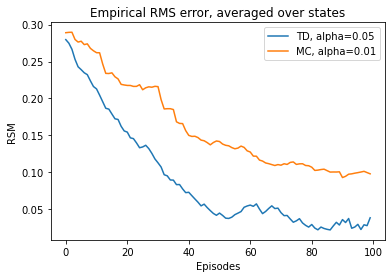

In [623]:
MC_ALPHA = [0.01]
TD_ALPHA = [0.05]
RMS_all = np.zeros((len(TD_ALPHA)+len(MC_ALPHA), EPISODES))

for i, alpha in enumerate(TD_ALPHA):
    RMS_all[i], _ = TD_prediction(alpha = alpha)
    plt.plot(RMS_all[i], label='TD, alpha='+str(alpha))

for j, alpha in enumerate(MC_ALPHA):
    RMS_all[len(TD_ALPHA)+j], _ = MC_prediction(alpha = alpha)
    plt.plot(RMS_all[len(TD_ALPHA)+j], label='MC, alpha='+str(alpha))

plt.xlabel('Episodes')
plt.ylabel('RSM')
plt.title("Empirical RMS error, averaged over states")
plt.legend()